In [1]:
import os
import json
import pickle
import pprint
import pandas as pd
import numpy as np
from sklearn.utils import resample
from sklearn.linear_model import LogisticRegression
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import precision_recall_fscore_support as p_r_f
from sklearn.metrics import auc
from sklearn.metrics import average_precision_score
from sklearn.externals import joblib
import matplotlib.pyplot as plt
import seaborn as sns

# Read and Process Data

In [2]:
# read ordinal encoded data
df = pd.read_csv('adult_oe_im.csv')
# or read one hot encoded data
#df = pd.read_csv('adult_ohe_im.csv')
df.head()

,age,workclass,education-num,status,occupation,relationship,race,sex,hours-per-week,income-class,capital-gain-zero,capital-loss-zero,is_USA,no_pay_or_work,bachelor_above
0,3.663562,7.0,13.0,4.0,1.0,1.0,4.0,1.0,40.0,0,0.0,1.0,1.0,0.0,1.0
1,3.912023,6.0,13.0,2.0,4.0,0.0,4.0,1.0,13.0,0,1.0,1.0,1.0,0.0,1.0
2,3.637586,4.0,9.0,0.0,6.0,1.0,4.0,1.0,40.0,0,1.0,1.0,1.0,0.0,0.0
3,3.970292,4.0,7.0,2.0,6.0,0.0,2.0,1.0,40.0,0,1.0,1.0,1.0,0.0,0.0
4,3.332205,4.0,13.0,2.0,10.0,5.0,2.0,0.0,40.0,0,1.0,1.0,0.0,0.0,1.0


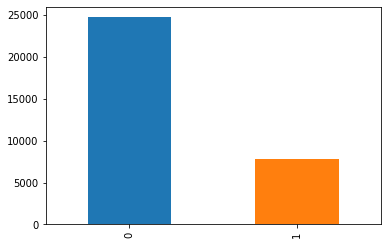

In [3]:
# imbalanced target
df['income-class'].value_counts().plot(kind='bar')

In [4]:
# ONLY balance training set, don't change the distribution of test set
train = df.sample(frac=0.7, replace=False, random_state=123)
test = df.drop(train.index)

In [5]:
print(train.shape)
print(test.shape)

(22793, 15)
(9768, 15)


In [6]:
high_income_train = train[train['income-class']==1]
low_income_train = train[train['income-class']==0]

In [7]:
print(high_income_train.shape)
print(low_income_train.shape)

(5503, 15)
(17290, 15)


In [8]:
high_income_upsampled_train = resample(high_income_train, replace=True, 
                                   n_samples=low_income_train.shape[0], random_state=123)
high_income_upsampled_train.shape

(17290, 15)

In [9]:
balanced_train = pd.concat([high_income_upsampled_train, low_income_train])
balanced_train.head()

,age,workclass,education-num,status,occupation,relationship,race,sex,hours-per-week,income-class,capital-gain-zero,capital-loss-zero,is_USA,no_pay_or_work,bachelor_above
8268,3.806662,6.0,13.0,2.0,4.0,0.0,4.0,1.0,50.0,1,1.0,1.0,1.0,0.0,1.0
28969,4.094345,4.0,10.0,2.0,3.0,0.0,3.0,1.0,32.0,1,1.0,1.0,1.0,0.0,0.0
30525,3.891820,5.0,10.0,2.0,10.0,5.0,4.0,0.0,65.0,1,1.0,1.0,1.0,0.0,0.0
5792,3.806662,5.0,9.0,2.0,4.0,0.0,4.0,1.0,55.0,1,0.0,1.0,1.0,0.0,0.0
4306,3.401197,4.0,9.0,2.0,13.0,0.0,4.0,1.0,40.0,1,1.0,1.0,1.0,0.0,0.0


In [10]:
# modeling
X_train, y_train = balanced_train.drop('income-class', axis=1), balanced_train['income-class']
X_test, y_test = test.drop('income-class', axis=1), test['income-class']

In [39]:
X_train.head()

,age,workclass,education-num,status,occupation,relationship,race,sex,hours-per-week,capital-gain-zero,capital-loss-zero,is_USA,no_pay_or_work,bachelor_above
0,3.81,6.00,13.00,2.00,4.00,0.00,4.00,1.00,50.00,1.00,1.00,1.00,0.00,1.00
1,4.09,4.00,10.00,2.00,3.00,0.00,3.00,1.00,32.00,1.00,1.00,1.00,0.00,0.00
2,3.89,5.00,10.00,2.00,10.00,5.00,4.00,0.00,65.00,1.00,1.00,1.00,0.00,0.00
3,3.81,5.00,9.00,2.00,4.00,0.00,4.00,1.00,55.00,0.00,1.00,1.00,0.00,0.00
4,3.40,4.00,9.00,2.00,13.00,0.00,4.00,1.00,40.00,1.00,1.00,1.00,0.00,0.00


# My Modeling

## Logistic Regression

In [11]:
clf = LogisticRegression(random_state=123).fit(X_train, y_train)
y_pred_train = clf.predict(X_train)
y_pred_test = clf.predict(X_test)
preds_prob_train = clf.predict_proba(X_train)[:, 1] # prob of class 1 ( >50K)
preds_prob_test = clf.predict_proba(X_test)[:, 1] # prob of class 1 ( >50K)

/Users/yuahoh/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [12]:
def report_pr_curve(y, preds_prob, no_skill_precision):
    precision, recall, thresholds = precision_recall_curve(y, preds_prob, pos_label=1)
    # draw the curve
    plt.title('Precision Recall Curve for Training Data')
    plt.plot(precision, recall, 'b')
    plt.plot([0, 1], [no_skill_precision, no_skill_precision],'r--')
    #plt.xlim([0, 1])
    #plt.ylim([0, 1])
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    return precision, recall, thresholds

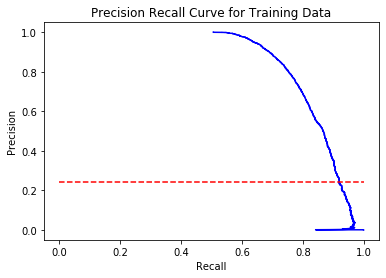

In [13]:
# precision recall curve for training data
no_skill_precision_train = high_income_train.shape[0] / (high_income_train.shape[0] + low_income_train.shape[0])
precision, recall, thresholds = report_pr_curve(y_train, preds_prob_train, no_skill_precision_train)

In [22]:
# auc_train = auc(recall, precision)
# auc_train

In [23]:
avg_precision_train = average_precision_score(y_train, preds_prob_train)
avg_precision_train

0.8398011311353581

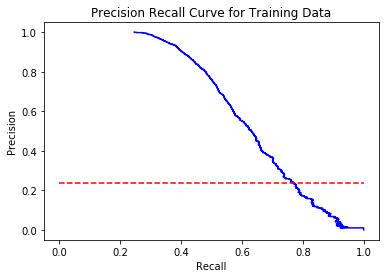

In [15]:
# precision recall curve for test data
no_skill_precision_test = y_test[y_test==1].shape[0] / (y_test[y_test==0].shape[0] + y_test[y_test==1].shape[0])
precision, recall, thresholds = report_pr_curve(y_test, preds_prob_test, no_skill_precision_test)

In [16]:
# auc_test = auc(recall, precision)
# auc_test

In [17]:
avg_precision_test = average_precision_score(y_test, preds_prob_test)
avg_precision_test

0.6296902554996804

In [19]:
# report_train = classification_report(y_train, y_pred_train)
# report_test = classification_report(y_test, y_pred_test)
# print(report_train, '\n')
# print(report_test)

In [20]:
# coef_df = pd.DataFrame({'ft': X_train.columns, 'coef': clf.coef_[0]})
# coef_df['abs_coef'] = coef_df['coef'].abs()
# coef_df.sort_values(by='abs_coef', ascending=False, inplace=True)
# coef_df

## Decision Tree

**NOTE:** Decision tree classifier with default params overfits training data. The overfitting can be identified by:
1. ~0.99 auc on training, and ~0.7 auc on test
2. extremely large and complex tree

Specifying 'min_samples_split': 0.005,'min_samples_leaf': 0.01,'max _features':'auto' reduces overfitting with auc on training drops to ~0.86 and auc on test increases to ~0.85, and the tree is much simpler.

In [24]:
tree_params = {'min_samples_split': 0.005, 
              'min_samples_leaf': 0.01,
              'max_features':'auto',
               'class_weight': None,
              'random_state': 123}

clf_tree = DecisionTreeClassifier(**tree_params).fit(X_train, y_train)

y_pred_train = clf_tree.predict(X_train)
y_pred_test = clf_tree.predict(X_test)
preds_prob_train = clf_tree.predict_proba(X_train)[:, 1] # prob of class 1 ( >50K)
preds_prob_test = clf_tree.predict_proba(X_test)[:, 1] # prob of class 1 ( >50K)

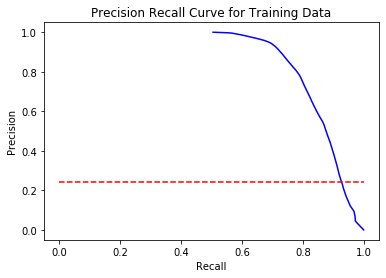

In [25]:
precision, recall, thresholds = report_pr_curve(y_train, preds_prob_train, no_skill_precision_train)

In [26]:
# auc_train = auc(recall, precision)
# auc_train

In [27]:
avg_precision_train = average_precision_score(y_train, preds_prob_train)
avg_precision_train

0.8512845472093025

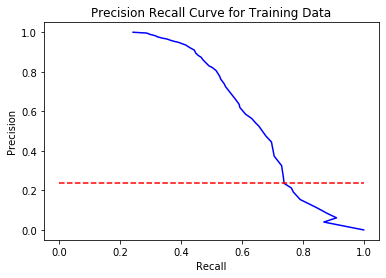

In [28]:
precision, recall, thresholds = report_pr_curve(y_test, preds_prob_test, no_skill_precision_test)

In [29]:
# auc_pr_test = auc(recall, precision)
# auc_pr_test

In [30]:
avg_precision_test = average_precision_score(y_test, preds_prob_test)
avg_precision_test

0.637629882432756

In [31]:
# report_train = classification_report(y_train, y_pred_train)
# report_test = classification_report(y_test, y_pred_test)
# print(report_train, '\n')
# print(report_test)

In [32]:
# imp_df = pd.DataFrame({'ft': X_train.columns, 'ft_imp': clf_tree.feature_importances_})
# imp_df.sort_values(by='ft_imp', ascending=False, inplace=True)
# imp_df

In [78]:
# fn = X_train.columns
# cn = ['<=50K', '>50K']
# tree.export_graphviz(clf_tree,
#                      out_file="tree_v2.dot",
#                      feature_names=fn, 
#                      class_names=cn,
#                      filled = True)

In [33]:
# while auc score for precision_recall on test data is low, roc auc score remains high. 
# It's a good example to show that roc score can be very misleading for imbalanced data.

# auc_test = roc_auc_score(y_test, preds_prob_test)
# print('auc_roc_test:', auc_test)

In [ ]:
# draw roc curve
# fpr, tpr, thresholds = roc_curve(y_train, preds_prob_train)
# auc_train = roc_auc_score(y_train, preds_prob_train)
# print('auc_train:', auc_train)

# plt.title('Receiver Operating Characteristic')
# plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % auc_train)
# plt.legend(loc = 'lower right')
# plt.plot([0, 1], [0, 1],'r--')
# #plt.xlim([0, 1])
# #plt.ylim([0, 1])
# plt.ylabel('True Positive Rate')
# plt.xlabel('False Positive Rate')
# plt.show()

# AutoML

In [40]:
import azureml
import azureml.core
from azureml.core.workspace import Workspace
from azureml.train.automl import AutoMLConfig
from azureml.core.experiment import Experiment
from azureml.core.model import Model
import logging

In [41]:
project_folder = './demo_automl'

if not os.path.isdir(project_folder):
    os.mkdir(project_folder)

print('autoML experiments will be created in {}.'.format(project_folder))

autoML experiments will be created in ./demo_automl.


In [42]:
# make sure you have the correct subscription id, resource group, and workspace name
existing_config = {
    "subscription_id": "a8d4385d-c984-403a-af97-763505802834",
    "resource_group": "rgbkmdatapipelinepoc",
    "name": "aml-digital-factory"}
ws = Workspace.get(**existing_config)

In [67]:
def run_experiments(workspace, exp_name, X_train, y_train, X_valid, y_valid, local_folder):
    automl_settings = {
        "iteration_timeout_minutes": 3, # Maximum time in minutes that each iteration can run for.
        "iterations": 10,
        "enable_early_stopping": True,
        "primary_metric": 'average_precision_score_weighted',
        "featurization": 'off',
        "verbosity": logging.INFO
    }

    # azure automl only supports: pandas df, azure dataset object, azure tabular dataset
    # can't directly use pyspark df even with spark context specified with sc (default sc in databricks)
    # solution 1: convert pyspark df to pandas df
    # solution 2: register databricks DBFS as an azure datastore, and create azure dataset object 
    # by reading data from the datastore
    # path: # to ensure we can retrieve models and related artifacts after experiments are done
    automl_config = AutoMLConfig(task='classification', 
                                 debug_log='automated_ml_errors.log',
                                 X=X_train,
                                 y=y_train, 
                                 X_valid=X_valid,
                                 y_valid=y_valid,
                                 whitelist_models=['DecisionTree', 'GradientBoosting', 'KNN',
                                                  'LogisticRegression', 'RandomForest', 'SVM'],
                                 path = local_folder,
                                 enable_voting_ensemble=False,
                                 enable_stack_ensemble=False,
                                 **automl_settings)

    experiment = Experiment(workspace, exp_name)
    local_run = experiment.submit(automl_config, show_output=True)
    return experiment, local_run

In [68]:
# make sure you create a different experiment name or your runs will overwrite others.
experiment, local_run = run_experiments(ws, 
                                        'Chapter_demo_autoML', 
                                        X_train=X_train, 
                                        y_train=y_train,
                                        X_valid=X_test,
                                        y_valid=y_test,
                                        local_folder=project_folder)

WARNING - The AutoMLConfig parameters, X and y, will soon be deprecated. Please refer to our documentation for the latest interface: https://aka.ms/AutoMLConfig


Running on local machine
Parent Run ID: AutoML_5f9ef519-80cf-4a02-a6e3-c59291877c43


****************************************************************************************************
DATA GUARDRAILS: 

TYPE:         Class balancing detection
STATUS:       PASSED
DESCRIPTION:  Your inputs were analyzed, and all classes are balanced in your training data.
              Learn more about imbalanced data: https://aka.ms/AutomatedMLImbalancedData

****************************************************************************************************
Current status: ModelSelection. Beginning model selection.

****************************************************************************************************
ITERATION: The iteration being evaluated.
PIPELINE: A summary description of the pipeline being evaluated.
DURATION: Time taken for the current iteration.
METRIC: The result of computing score on the fitted pipeline.
BEST: The best observed score thus far.
*******************************

In [45]:
def find_run(exp, parent_run_id, run_preprocessor, run_algo, metric, metric_score):
    # get a list of runs that meet the specified requirements:
    # 1) under a parent run id
    # 2) with a specific data preprocessor
    # 3) with a specific algorithm
    # 4) with metric above a certain threshold
    runs = exp.get_runs()
    my_run = []
    for run in runs:
        parent_run = run
        if parent_run.run_id == parent_run_id: 
            children = list(run.get_children())
            for child_run in children:  
                properties = child_run.get_properties()
                if ((properties['run_preprocessor'] == run_preprocessor) 
                    & (properties['run_algorithm'] == run_algo) 
                    & (child_run.get_metrics()[metric] > metric_score)):
                    my_run.append(child_run)
    return my_run

In [46]:
def get_run_model(run, output_file_path):
    # get the model associated with a run: an Azure pipeline object that can be used to predict, not a pkl file.
    run.download_file('outputs/model.pkl', output_file_path=output_file_path)
    print(os.listdir(output_file_path))

    local_model_path = os.path.join(output_file_path, 'model.pkl')
    # either load it from a local path or from registration path on Azure ml, using get_reg_model_path()
    joblib_model = joblib.load(local_model_path) 
    pp = pprint.PrettyPrinter(indent=4)
    pp.pprint(joblib_model.steps)
    return joblib_model

In [49]:
# retrieving runs that meet our requirements
my_runs = find_run(experiment, 
                   'AutoML_20b4ef18-eb3b-4431-ad35-1021148f3af3', 
                   'StandardScalerWrapper', 
                   'GradientBoosting', 
                   'average_precision_score_weighted', 
                   0.86)

In [50]:
my_runs

[Run(Experiment: Chapter_demo_autoML,
 Id: AutoML_20b4ef18-eb3b-4431-ad35-1021148f3af3_6,
 Type: None,
 Status: Completed)]

In [51]:
joblib_model_0 = get_run_model(my_runs[0], project_folder)

['model.pkl', '.azureml']
[   (   'datatransformer',
        DataTransformer(enable_dnn=None, enable_feature_sweeping=None,
        feature_sweeping_config=None, feature_sweeping_timeout=None,
        featurization_config=None, force_text_dnn=None,
        is_cross_validation=None, is_onnx_compatible=None, logger=None,
        observer=None, task=None, working_dir=None)),
    (   'StandardScalerWrapper',
        <azureml.automl.runtime.shared.model_wrappers.StandardScalerWrapper object at 0x7fbc451a2cc0>),
    (   'GradientBoostingClassifier',
        GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=10,
              max_features=0.1, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=0.01, min_samples_split=0.10368421052631578,
              min_weight_fraction_leaf=0.0, n_estimators=200,
              n_iter_no_change=None, presort='auto', rand

In [ ]:
# Now go to your workspace on Microsoft Azure Machine Learning Portal to check on artifacts.
# open: ml.azure.com and login using your Braskem credentials.